## Book Recommendations

### Problem Description
- An online-based book platform (Goodreads) was experiencing the problem of losing potential revenue due to a 20% decrease in user activity.
- After conducting research, the Goodreads team found that users felt confused and lost when trying to choose the books they wanted to read on Goodreads, which has nearly ~10,000 books. In addition, users also experience a decrease in interest in reading because they no longer find book preferences that match their interests.

### Business Objective
- Improve user experience and interest in reading while using the platform by solving the problem of confusion when choosing books.

### Solution
Create book recommendations to help users choose books easily and eliminate user difficulties in using the Goodreads platform.

The recommendation approach that will be carried out is:
1. Non-personalized: popularity-based recommendation
2. Personalized: collaborative filtering

Approaches in personalized recommender systems can be divided based on the presence of interaction data (implicit/explicit):
1. Implicit data is taken from indirect user behavior such as book clicks, time spent scrolling through book pages, purchasing items, or adding books to the reading list.
2. Explicit data is derived from direct user assessments such as book ratings, book reviews or feedback on user opinions of certain books.

Related to this problem, there is direct interaction by the user in the form of rating data. So that the approach to be taken is to use *collaborative filtering*.


### Steps for Building Book Recommender System

1. **Load the dataset and preparation**
    <br> a. change data type id to string
    <br> b. clean duplicated data in each dataset
    <br> c. cek baris yg kosong
    <br>
2. **EDA**
    <br> a. Distribusi user melakukan rating
    <br> b. Top rating dan most popular book (top rating dilihat dari average rating, sedangkan popular book dilihat dari ratings count)
    <br> c. What influenced book ratings, mungkin semacam pearson correlation
    <br>
3. Melakukan non personalized recommendations (top K)
<br>
4. Melakukan personalized recommendations based on genre (top K each genre)

## 1. Load the dataset and preparation

### Data Description
- The data comes from [Goodbooks dataset](https://github.com/zygmuntz/goodbooks-10k).
- The dataset contains 10,000 books and 5,976,479 ratings.

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [27]:
ratings = pd.read_csv('data/ratings.csv')
books = pd.read_csv('data/books.csv')
to_read = pd.read_csv('data/to_read.csv')
book_tags = pd.read_csv('data/book_tags.csv')
tags = pd.read_csv('data/tags.csv')

In [28]:
# a. Change data type for IDs columns to string
ratings[['user_id', 'book_id']] = ratings[['user_id', 'book_id']].astype(str)
books[['book_id', 'goodreads_book_id', 'best_book_id', 'work_id']] = books[['book_id', 'goodreads_book_id', 'best_book_id', 'work_id']].astype(str)
to_read[['user_id', 'book_id']] = to_read[['user_id', 'book_id']].astype(str)
book_tags[['goodreads_book_id', 'tag_id']] = book_tags[['goodreads_book_id', 'tag_id']].astype(str)
tags['tag_id'] = tags['tag_id'].astype(str)

In [29]:
## b. drop duplicated rows
print("Books shape before drop dup: ", books.shape)
print("Ratings shape before drop dup: ", ratings.shape)
print("To-read shape before drop dup: ", to_read.shape)
books.drop_duplicates(subset = ['book_id', 'goodreads_book_id'], inplace = True)
ratings.drop_duplicates(subset=['user_id','book_id'], inplace = True)
to_read.drop_duplicates(subset=['user_id','book_id'], inplace = True)
print("Books shape after drop dup: ", books.shape)
print("Ratings shape after drop dup: ", ratings.shape)
print("To-read shape after drop dup: ", to_read.shape)

Books shape before drop dup:  (10000, 23)
Ratings shape before drop dup:  (5976479, 3)
To-read shape before drop dup:  (912705, 2)
Books shape after drop dup:  (10000, 23)
Ratings shape after drop dup:  (5976479, 3)
To-read shape after drop dup:  (912705, 2)


In [30]:
## c. clean duplicated data in each dataset

#check the total number of null values in rating_data
print("Missing values on Ratings Data: \n", ratings.isnull().sum())

Missing values on Ratings Data: 
 user_id    0
book_id    0
rating     0
dtype: int64


In [31]:
# Books have many missing data but not really useful for this analysis so we will fill it with 'unknown' or NA
print("Missing values on Books Data: \n", books.isnull().sum())

Missing values on Books Data: 
 book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64


In [65]:
# d. Memisahkan Genre

genres = ["Art", "Biography", "Business", "Chick Lit", "Children's", "Christian", "Classics",
          "Comics", "Contemporary", "Cookbooks", "Crime", "Ebooks", "Fantasy", "Fiction",
          "Gay and Lesbian", "Graphic Novels", "Historical Fiction", "History", "Horror",
          "Humor and Comedy", "Manga", "Memoir", "Music", "Mystery", "Nonfiction", "Paranormal",
          "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science", "Science Fiction", 
          "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel", "Young Adult"]
genres = list(map(str.lower, genres))

tags['tag_name_lower'] = tags['tag_name'].str.lower()
available_genres = tags.loc[tags.tag_name_lower.str.lower().isin(genres)]
available_genres.head()

,tag_id,tag_name,tag_name_lower
2938,2938,art,art
4605,4605,biography,biography
5951,5951,business,business
7077,7077,christian,christian
7457,7457,classics,classics


In [84]:
tags['genre_list'] = [[]] * tags.shape[0]

def create_genre_list(tag):
    
    genre_list = []
    string_tag = str(tag)
    for genre in genres:
        if (genre in string_tag) & ('non' not in string_tag):
            genre_list.append(genre)
        else:
            pass
    return genre_list
            

# Add tags
tags['genre_list'] = tags.apply(lambda row: create_genre_list(row['tag_name_lower']), axis = 1)

In [85]:
tags[ tags.genre_list.str.len() > 1 ]

,tag_id,tag_name,tag_name_lower,genre_list
786,786,2015-rmangas-comics,2015-rmangas-comics,"[comics, manga]"
1000,1000,3-mystery-thrillers,3-mystery-thrillers,"[mystery, thriller]"
1183,1183,6-travel-fiction-series,6-travel-fiction-series,"[fiction, travel]"
1476,1476,about-to-read-mystery-thriller,about-to-read-mystery-thriller,"[mystery, thriller]"
1553,1553,action-suspense-thriller,action-suspense-thriller,"[suspense, thriller]"
...,...,...,...,...
33005,33005,ya-contemporary-romance,ya-contemporary-romance,"[contemporary, romance]"
33036,33036,ya-paranormal-romance,ya-paranormal-romance,"[paranormal, romance]"
33037,33037,ya-paranormal-romance-fantasy,ya-paranormal-romance-fantasy,"[fantasy, paranormal, romance]"
33047,33047,ya-science-fiction,ya-science-fiction,"[fiction, science]"


In [ ]:
# join with books
books_with_genre = book_tags.copy()

## 2. EDA
    a. Distribusi user melakukan rating

In [39]:
user_counts = pd.DataFrame(ratings['user_id'].value_counts())
user_counts.reset_index(drop = False, inplace=True)
user_counts.columns = ['user_id', 'rated_books']

user_counts_v2 = pd.DataFrame(user_counts['rated_books'].value_counts()).reset_index(drop = False)
user_counts_v2.columns = ['rated_books','user_counts']
user_counts_v2.sort_values(by = 'rated_books', inplace=True)
user_counts_v2.reset_index(drop = True, inplace= True)

In [48]:
mean_floor = int(np.floor(user_counts_v2.rated_books.mean()))
median_floor = int(np.floor(user_counts_v2.rated_books.median()))

print("User yang melakukan rating: ", user_counts.user_id.nunique())
print("Range banyaknya buku yg dirating user: ", user_counts_v2.rated_books.min(), " sampai ", user_counts_v2.rated_books.max())
print("Mean banyaknya buku yg dirating user: ", mean_floor)
print("Median banyaknya buku yg dirating user: ", median_floor)

User yang melakukan rating:  53424
Range banyaknya buku yg dirating user:  19  sampai  200
Mean banyaknya buku yg dirating user:  109
Median banyaknya buku yg dirating user:  109


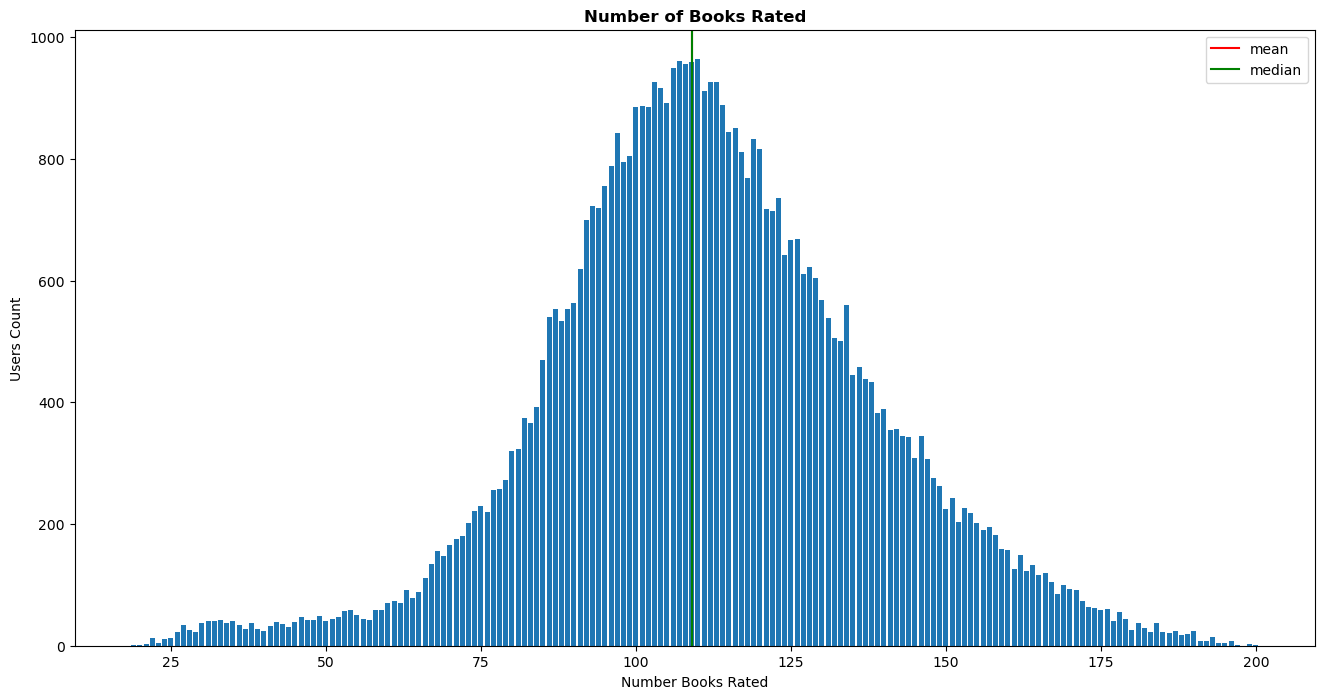

In [55]:
plt.figure(figsize=(16,8))
plt.title("Number of Books Rated", weight='bold')
plt.bar(x=user_counts_v2.rated_books,height='user_counts', data=user_counts_v2)
plt.axvline(x=mean_floor, color = 'red', label = 'mean')
plt.axvline(x=median_floor, color = 'green', label = 'median')
plt.xlabel("Number Books Rated")
plt.ylabel("Users Count")
plt.legend(loc="upper right")

Sebanyak 53424 user melakukan rating dengan range dari 20 buku hingga 200an buku. Rata-rata user melakukan meaning 109 buku.

## 2. Non-Personalized (Popularity-based Recommendations)

We already have `average_rating` column.

In [10]:
#count the number of ratings given for each book and store the result in a new df called 'rating_count'
rating_count = ratings.groupby('book_id').count()['rating'].reset_index()
rating_count.rename(columns={'rating':'rating_count'}, inplace=True)

#count the mean of ratings given for each book and store the result in a new df called 'mean_rating'
mean_rating = ratings.groupby('book_id').mean().round(2)['rating'].reset_index()
mean_rating.rename(columns={'rating':'mean_rating'}, inplace=True)

#merge 'rating_count' dataframe with 'mean_rating' dataframe based on 'book_id' column
popular = rating_count.merge(mean_rating, on='book_id')

#merge df 'popular' with df 'books' based on column 'book_id' then select specific columns and remove duplicate rows based on 'book_id'
popular = popular.merge(books, on="book_id").drop_duplicates("book_id")[["book_id","rating_count", "average_rating", "mean_rating","authors","original_publication_year","original_title","image_url"]]
popular

,book_id,rating_count,average_rating,mean_rating,authors,original_publication_year,original_title,image_url
0,1,22806,4.34,4.28,Suzanne Collins,2008.0,The Hunger Games,https://images.gr-assets.com/books/1447303603m...
1,10,13445,4.24,4.19,Jane Austen,1813.0,Pride and Prejudice,https://images.gr-assets.com/books/1320399351m...
2,100,6343,4.02,3.98,Barbara Kingsolver,1998.0,The Poisonwood Bible,https://images.gr-assets.com/books/1412242487m...
3,1000,1239,4.05,3.97,Leigh Bardugo,2012.0,Shadow and Bone,https://images.gr-assets.com/books/1339533695m...
4,10000,111,4.00,4.01,John Keegan,1998.0,The First World War,https://images.gr-assets.com/books/1403194704m...
...,...,...,...,...,...,...,...,...
9995,9995,202,3.09,3.09,Herman Melville,1924.0,"Billy Budd, Sailor",https://s.gr-assets.com/assets/nophoto/book/11...
9996,9996,141,4.09,4.01,Ilona Andrews,2010.0,Bayou Moon,https://images.gr-assets.com/books/1307445460m...
9997,9997,93,4.25,4.45,Robert A. Caro,1990.0,Means of Ascent,https://s.gr-assets.com/assets/nophoto/book/11...
9998,9998,102,4.35,4.32,Patrick O'Brian,1977.0,The Mauritius Command,https://images.gr-assets.com/books/1455373531m...


### 3. Personalized RecSys (Collaborative Filtering)

In [11]:
#load library
import copy
import surprise
from surprise import accuracy, Dataset, Reader, KNNBaseline, BaselineOnly, SVD
from surprise.model_selection.search import RandomizedSearchCV
from surprise.model_selection import cross_validate, train_test_split

In [12]:
# create utility data
# Initiate rating scale
reader = Reader(rating_scale = (1, 5))
# Data Preparation
utility_data = Dataset.load_from_df(
                    df = ratings[['user_id', 'book_id', 'rating']].copy(),
                    reader = reader
                )
utility_data

In [13]:
# Split Train Test
# Create a function
def train_test_split(utility_data, test_size, random_state):
    """
    Train test split the data
    ref: https://surprise.readthedocs.io/en/stable/FAQ.html#split-data-for-unbiased-estimation-py

    Parameters
    ----------
    utility_data : Surprise utility data
        The sample of whole data set

    test_size : float, default=0.2
        The test size

    random_state : int, default=42
        For reproducibility

    Returns
    -------
    full_data : Surprise utility data
        The new utility data

    train_data : Surprise format
        The train data

    test_data : Surprise format
        The test data
    """
    # Deep copy the utility_data
    full_data = copy.deepcopy(utility_data)

    # Generate random seed
    np.random.seed(random_state)

    # Shuffle the raw_ratings for reproducibility
    raw_ratings = full_data.raw_ratings
    np.random.shuffle(raw_ratings)

    # Define the threshold
    threshold = int((1-test_size) * len(raw_ratings))

    # Split the data
    train_raw_ratings = raw_ratings[:threshold]
    test_raw_ratings = raw_ratings[threshold:]

    # Get the data
    full_data.raw_ratings = train_raw_ratings
    train_data = full_data.build_full_trainset()
    test_data = full_data.construct_testset(test_raw_ratings)

    return full_data, train_data, test_data


In [14]:
full_data, train_data, test_data = train_test_split(utility_data,
                                                    test_size = 0.2,
                                                    random_state = 42)

### a. Baseline Mean Prediction 
Our Baseline Model just simply predict ratings using mean from all training data provided to model.

In [15]:
from surprise.model_selection.search import RandomizedSearchCV
from surprise import AlgoBase, SVD
from surprise.model_selection import cross_validate

In [16]:
class MeanPrediction(AlgoBase):
    '''Baseline prediction. Return global mean as prediction'''
    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        '''Fit the train data'''
        AlgoBase.fit(self, trainset)

    def estimate(self, u, i):
        '''Perform the estimation/prediction.'''
        est = self.trainset.global_mean
        return est

In [17]:
model_mean_pred = MeanPrediction()
model_mean_pred

In [18]:
cv_baseline = cross_validate(algo = model_mean_pred,
                             data = full_data,
                             cv = 5,
                             measures = ['rmse'])

cv_baseline_rmse = cv_baseline['test_rmse'].mean()
cv_baseline_rmse

### b. KNN (User to User Approach)

The total number of users is more than the number of items, so for personalized recommender systems, *User-to-User Collaborative Filtering (User CF)* is used.


In [1]:
# #initialization of parameters that will be used in a randomized search
# #for hyperparameters in the recommendation model with the KNNBaseline method
# param_dist = {'k':[10, 25, 50, 100, 200],
#           'sim_options':{'name':['cosine'],'user_based':['True', 'False']}}

In [2]:
# #randomized search for hyperparameters in the recommendation model with the KNNBaseline method
# knn_user2user = RandomizedSearchCV(algo_class=KNNBaseline, param_distributions = param_dist, cv=5)

In [3]:
# #process search hyperparams
# knn_user2user.fit(data=full_data)

In [4]:
# knn_user2user.best_params["rmse"]

### c. Funk SVD

In [ ]:
#create dictionary of parameter
params_SVD = {'lr_all' : [1,0.1,0.01,0.001], 'n_factors' : [50,100],
              'reg_all' : [1,0.1,0.01]
              }  

In [ ]:
# tuning_svd = RandomizedSearchCV(algo_class=SVD, param_distributions = params_SVD, cv=5)
# tuning_svd.fit(data=full_data)

In [ ]:
summary_df = pd.DataFrame({'Model': ['Baseline', 'Funk SVD'],
                           'CV Performance - RMSE': [cv_baseline_rmse,tuning_svd.best_score['rmse'] ],
                           'Model Condiguration':['N/A',f'{tuning_svd.best_params["rmse"]}']})

summary_df

In [ ]:
best_params_svd = tuning_svd.best_params['rmse']
best_params_svd

In [ ]:
# save
with open('best_params_svd.pkl','wb') as f:
    pickle.dump(best_params_svd,f)

In [ ]:
# save
loaded_model = pickle.load(open('best_params_svd.pkl', 'rb'))